In [ ]:
#IMPORT LIBRARIES

%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import random
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


In [ ]:
#IMPORT DATA

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

datadir = '/content/drive/My Drive/MWI-public-custom'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

Mounted at /content/drive


In [ ]:
#CREATE TRAINING SET

from skimage import color
training_set=[]
PIXELS=200
categories=["HAZE", "RAINY", "SNOWY", "SUNNY"]

def create_training_set():
    for category in categories:
    path = os.path.join(trainingset, category) #path to HAZE, RAINY, SNOWY or SUNNY
    class_number = categories.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #path to images within each class
        new_array = cv2.resize(img_array, (PIXELS, PIXELS))
        training_set.append([new_array, class_number])

create_training_set()
print(len(training_set))      


400


In [ ]:
#CREATE TEST SET

test_set=[]
PIXELS=200
categories=["HAZE", "RAINY", "SNOWY", "SUNNY"]

def create_test_set():
    for category in categories:
    path = os.path.join(testset, category) #path to HAZE, RAINY, SNOWY or SUNNY
    class_number = categories.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #path to images within each class
        new_array = cv2.resize(img_array, (PIXELS, PIXELS))
        test_set.append([new_array, class_number])

create_test_set()
print(len(test_set))      

400


In [ ]:
#CREATE AUGMENTED TRAINING SET

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import color


augmented_training_set=[]

def create_augmented_training_set():
    for category in categories:
    path = os.path.join(trainingset, category) #path to HAZE, RAINY, SNOWY or SUNNY
    class_number = categories.index(category)
    for img in os.listdir(path):
        #Add original image to dataset
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #path to images within each class
        new_array = cv2.resize(img_array, (PIXELS, PIXELS))
        augmented_training_set.append([new_array/255, class_number]) #import already normalized color images
        #Add Spectral Image to dataset
        spectral_image = cv2.applyColorMap(new_array, cv2.COLORMAP_RAINBOW)
        augmented_training_set.append([spectral_image/255, class_number])
        #Add blurred version of the image to the dataset
        blurred_image = cv2.GaussianBlur(new_array, (5,5), cv2.BORDER_DEFAULT) 
        augmented_training_set.append([blurred_image/255, class_number])
        #Add edge images
        edge_image = cv2.Canny(new_array, 100, 200)
        edge_image = color.gray2rgb(edge_image)
        augmented_training_set.append([edge_image/255, class_number])
        #Compute FFT
        img_transform = new_array
        img_transform = color.rgb2gray(img_transform)
        f = np.fft.fft2(img_transform)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        #Apply HPF and IFFT
        rows, cols= img_transform.shape
        crow,ccol= round(rows/2) , round(cols/2)
        fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        #Get back to a "color" image 
        img_back = color.gray2rgb(img_back)
        #augmented_training_set.append([img_back, class_number])
        
create_augmented_training_set()
print(len(augmented_training_set))

1600


In [ ]:
#SHUFFLE THE DATA

random.shuffle(training_set)
random.shuffle(test_set)
random.shuffle(augmented_training_set)

In [ ]:
#SEPARATE FEATURES AND LABELS

x_train=[]
y_train=[]

for features, label in training_set:
    x_train.append(features)
    y_train.append(label)

x_test=[]
y_test=[]

for features, label in test_set:
    x_test.append(features)
    y_test.append(label)

x_train_aug=[]
y_train_aug=[]

for features, label in augmented_training_set:
    x_train_aug.append(features)
    y_train_aug.append(label)

#Convert features and labels to NumpyArrays
x_train=np.array(x_train).reshape(-1, PIXELS, PIXELS, 3)
x_test=np.array(x_test).reshape(-1, PIXELS, PIXELS, 3)
x_train_aug=np.array(x_train_aug).reshape(-1, PIXELS, PIXELS, 3)

y_train=np.array(y_train)
y_train_aug=np.array(y_train_aug)

#Normalize training and test set
x_test=x_test/255
x_train=x_train/255

In [ ]:
#CREATE THE MODEL

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
    
#C1
model.add(Conv2D(80, kernel_size=(1, 1), strides=(2, 2), activation='relu', input_shape=x_train.shape[1:], padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

#C2
model.add(Conv2D(60, kernel_size=(1, 1), strides=(2, 2), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

#C3
model.add(Conv2D(40, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

#flatten data
model.add(Flatten())

#D1
model.add(Dense(100, activation='relu'))#, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))

#Output Layer 
model.add(Dense(4, activation="softmax"))

#Compile the generated model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 80)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 80)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 60)        4860      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 40)        2440      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 40)        0         
_________________________________________

In [ ]:
#TRAINING SETUP 
from keras import callbacks

nepochs = 20       # nr. of learning steps
batch_size = 16    # batch_size
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=4) # early stopping condition 

h=model.fit(x_train, y_train, batch_size=batch_size, epochs=nepochs, validation_split=0.2, validation_data=(x_test, y_test), callbacks=[stopping])

Train on 400 samples, validate on 400 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/sample - loss: 1.3124 - acc: 0.4175 - val_loss: 1.0254 - val_acc: 0.6250
Epoch 2/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.9062 - acc: 0.6075 - val_loss: 0.7878 - val_acc: 0.6975
Epoch 3/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.6983 - acc: 0.6925 - val_loss: 0.8509 - val_acc: 0.6700
Epoch 4/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.6475 - acc: 0.7500 - val_loss: 0.7491 - val_acc: 0.7125
Epoch 5/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.5576 - acc: 0.7900 - val_loss: 0.8017 - val_acc: 0.7025
Epoch 6/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.5111 - acc: 0.7950 - val_loss: 0.7416 - val_acc: 0.7200
Epoch 7/20
400/400 [==============================] - 1s 1ms/sample - loss: 0.4302 - acc: 0.8150 - val_loss: 0.7163 - val_acc: 0.7200
Epoch 8/20
400/4

In [ ]:
#PERFORMANCE METRICS PLOT

num_classes=4
preds= model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)
y_pred = keras.utils.to_categorical(y_pred, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(classification_report(y_test, y_pred, labels=None, digits=3))

[[92  2  5  1]
 [10 65 22  3]
 [20 29 51  0]
 [ 9 10  4 77]]
              precision    recall  f1-score   support

           0      0.702     0.920     0.797       100
           1      0.613     0.650     0.631       100
           2      0.622     0.510     0.560       100
           3      0.951     0.770     0.851       100

   micro avg      0.713     0.713     0.713       400
   macro avg      0.722     0.713     0.710       400
weighted avg      0.722     0.713     0.710       400
 samples avg      0.713     0.713     0.713       400



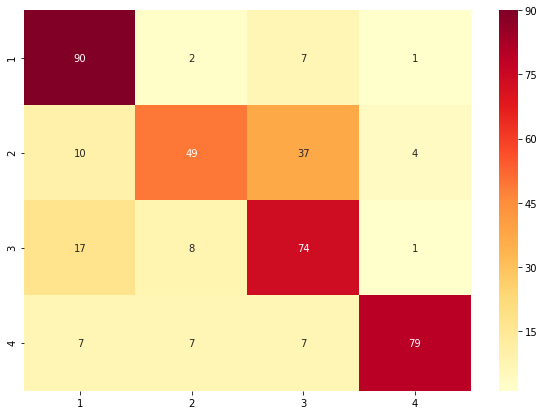

In [ ]:
#CONFUSION MATRIX PLOT

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cmap = 'YlOrRd'
cmap = 'PuBuGn'
cmap = 'inferno'
cmap = 'Oranges'

array = [[90,  2, 7,  1],
 [ 10, 49, 37,  4],
 [17,  8, 74,  1],
 [ 7,  7,  7, 79]]
df_cm = pd.DataFrame(array, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, cmap= 'YlOrRd', annot=True)

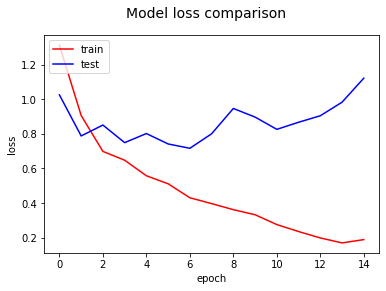

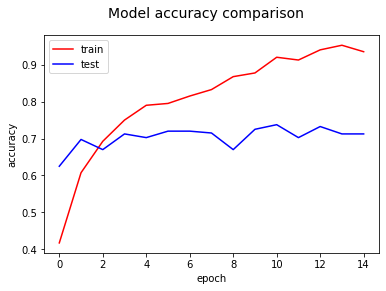

In [ ]:
#LOSS AND ACCURACY PLOTS

#Loss comparision
plt.plot(h.history['loss'],'r')
plt.plot(h.history['val_loss'],'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.suptitle('Model loss comparison', fontsize=14)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Accuracy comparison
plt.plot(h.history['acc'],'r')
plt.plot(h.history['val_acc'],'b')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.suptitle('Model accuracy comparison', fontsize=14)
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#SAVE THE MODEL

models_dir = datadir + '/models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model, '4classes_KiffaNet_20_epochs_augmented data')


Model saved successfully on file /content/drive/My Drive/MWI-public-custom/models/4classes_KiffaNet_20_epochs_augmented data.h5

